# Lectura de datos

Cargamos las librerias. Keras es la mejor libreria de deep learning para principiantes.

In [37]:
import numpy as np 
import pandas as pd 
import os
import pandas as pd
import numpy as np
import keras
import pickle

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import keras.optimizers

In [38]:
import keras
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8642855611773779168
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9224895857
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3525081596162591650
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Leemos nuestro train.xlsx y mostramos las clases con os que vamos a clasificar nuestros tweets

In [39]:
data = pd.read_excel('train-20190402-08_55_19.xlsx') # Load the `train` file
data = data.sample(frac=1) # Show a sample of the dataset
#data = data.loc[(data["party"]=="erc") | (data["party"]=="jxcat")]
print(set(data.party.values))
data = data.reset_index()
print(len(list(data['text'].str.split(' ', expand=True).stack().unique())))

{'psc', 'cup', 'bcncapital', 'bcomu', 'vallsbcn', 'erc', 'pp', 'jxcat'}
48789


In [40]:
data.head()

,index,Id,username,party,text,created_at,retweet_count,favorite_count
0,6055,6055,AdaColau,bcomu,Avui al carrer Gran de Sant Andreu es respira ...,2019-03-02 15:07:21,100,361
1,56,56,montsebenedi,erc,".@menagadea t’hem trobat a faltar. Gràcies, gr...",2018-09-30 20:01:34,1,4
2,6521,6521,neusmunte,jxcat,El nom de l’aeroport de #Barcelona\nEl color d...,2018-12-21 11:44:21,45,125
3,3990,3990,dianacoromines,bcncapital,És trist veure com Marcel Mauri (president d'Ò...,2019-03-13 20:46:31,217,407
4,1208,1208,janetsanz,bcomu,El feixisme no té cabuda ni a #9Barris ni enll...,2018-07-24 10:31:50,17,20


Dividimos nuestro dataset en training y test. El propio algoritmo de red neuronal de keras nos separara el set de validacion asi que ahora no nos preocupamos de esto.

In [41]:
train_size = int(len(data) * .8)

train_posts = data['text'][:train_size]
train_tags = data['party'][:train_size]

test_posts = data['text'][train_size:]
test_tags = data['party'][train_size:]

In [42]:
import re
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

def get_full(username, df):
    """ Get all tweets from a user
    """
    text_series = df[df['username'] == username]['text']
    all_text = " ".join(text_series)
    return all_text
  
def filter_single(text):
    """remove all single characters
    """
    return re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

def get_full_party(party, df):
    """ Get all tweets from a party
    """
    text_series = df[df['party'] == party]['text']
    all_text = " ".join(text_series)
    return all_text

def stop_words():
    """ Get the stop words
    """
    #stpwords=stopwords.words('catalan')
    stpwords=stopwords.words('english')
    stpwords+=stopwords.words('spanish')
    stpwords.append("dels")
    stpwords.append("als")
    stpwords.append("q")
    stpwords.append("hem")
    stpwords.append("d'")
    stpwords.append("d’")
    stpwords.append("ho")
    stpwords.append("hi")
    stpwords.append("pel")
    return stpwords
    
def filter_mentions(text):
    """ Filter all mentions
    """
    return re.sub("@\S+", "", text)

def filter_hashtags(text):
    """ Filter all hashtags
    """
    return re.sub("#\S+", "", text)

def get_hashtags_only(text):
    """
    """
    return re.findall("#\S+", text)
def clean_text(text):
    text = re.sub(r" c s ", " cs ", text)
    text = re.sub(r"à", "a", text)
    text = re.sub(r"á", "a", text)
    text = re.sub(r"è", "e", text)
    text = re.sub(r"é", "e", text)
    text = re.sub(r"ò", "o", text)
    text = re.sub(r"ó", "o", text)
    text = re.sub(r"í", "i", text)
    text = re.sub(r"ú", "u", text)
    text = text.lower()
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
# aqui pasamos el clean_text
stop = stop_words()
train_posts = train_posts.map(lambda com : clean_text(com))
train_posts = train_posts.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
test_posts = test_posts.map(lambda com : clean_text(com))
test_posts = test_posts.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


En esta celda definimos el numero de labels (partidos pol�ticos), numero de palabras en nuestro bag of words (vocab_size) y el batch size que es el numero de tweets que la red neuronal va a entrenar en cada step. El batch size existe porque si pasaramos de uno en uno los tweets el entrenamiento seria eterno. Adem�s generamos el tokenizador con nuestro vocabulario y lo integramos para nuestros tweets de training. Una vez generado este tokenizador lo aplicamos tanto en los tweets de test y los de train. Con esto obtenemos el vector de caracteristicas. Importante que nuestro contador tiene en cuenta la frequencia de la palabra y su aparacion en todos los tweets (mode = "tfidf").

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0, lowercase=True,ngram_range=(1,1))
vectorizer.fit(train_posts)
vectorizer.vocabulary_
x_train = vectorizer.transform(train_posts).toarray()
vocab_size = np.shape(x_train)[1]
x_test = vectorizer.transform(test_posts).toarray()
print(vocab_size)

24241


En esta celda pasamos de labels categoricas a lables vecotrizadas que es lo que la red neuronal entiende. Ej pp = [0,1,0,0,0,0] psc = [0,0,0,0,0,1]

In [44]:
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)
print(y_test)

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]]


In [45]:
print(x_train.shape)

(5775, 24241)


# Neural Network

En estas celdas definimos el modelo, es dificil explicar DL aqui mismo pero os dejo un video muy basico para haceros una idea https://www.youtube.com/watch?v=aircAruvnKk

In [46]:
first_layer = 512 #512
second_layer = 256 #512
num_epochs = 5 # 5

In [47]:
from keras.regularizers import l2
model = Sequential()
model.add(Dense(first_layer,input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dense(first_layer))
model.add(Activation('relu'))
model.add(Dense(8))
model.add(Activation('softmax'))
model.summary()

optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
 
history = model.fit(x_train, y_train,
                    batch_size=10,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               12411904  
_________________________________________________________________
activation_22 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_23 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 4104      
_________________________________________________________________
activation_24 (Activation)   (None, 8)                 0         
Total params: 12,678,664
Trainable params: 12,678,664
Non-trainable params: 0
________________________________________________________________

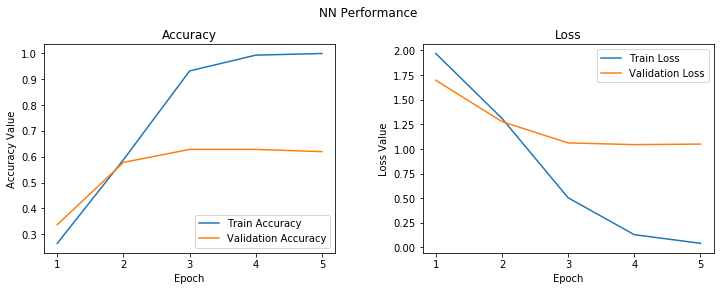

In [48]:
import matplotlib.pylab as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('NN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,6))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, 6, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, 6, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

En esta celda evaluamos nuestro modelo y mostramos las prediciones en el test. Por peticion popular ahora solo se muestran los errores.

In [49]:
score = model.evaluate(x_test, y_test,
                       batch_size=10, verbose=1)

print('Test accuracy:', score)

text_labels = encoder.classes_

predicted_label = [0] * len(x_test)
for i in range(len(x_test)):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label[i] = text_labels[np.argmax(prediction[0])]
    if test_tags.iloc[i] != predicted_label[i]:
        print('Text:' + data["text"][train_size+i])
        print('Actual label:' + test_tags.iloc[i])
        print("Predicted label: " + predicted_label[i])

1444/1444 [==============================] - 0s 303us/step
Test accuracy: [1.2071558400121751, 0.5997229986862793]
Text:Fases de la superstició:
1) Estem construint les estructures d'estat.
2) Europa no ho permetrà.
3) Si som super mega pacífics aconseguirem la independència (si no ho veieu així, ja creixereu)
4) La cova del monestir de Rila ens donarà la independència. 
Actual label:cup
Predicted label: bcncapital
Text:El anticatalanismo le ha costado a la Generalitat Valenciana once condenas en tres años, pero nadie se plantea un 155 por eso, no? 
Actual label:bcncapital
Predicted label: bcomu
Text:Valoració a Catalunya de la monarquia (segons el CEO). 
Sí, més del 60% li dóna un 0.
Visca la República!!! 
Actual label:jxcat
Predicted label: erc
Text:A veure @manuelvalls 1. En quin article del codi penal diu que una consulta es un delicte? 2. Hauries de respectar les majories democràtiques d’una institució en la seva lliure expressió. 3. Ara que et manifestes amb Vox, dorms tranquil? 

Text:Fins els nassos d’escoltar que els polis de l’1O eren bons professionals. Va ser una actuació salvatge, desproporcionada i a més inútil perquè votar, vam votar. I en @zoidoJI desconeix el que vol. Vergonya
Actual label:erc
Predicted label: bcncapital
Text:tot el suport @Joan_Melenchon davant dels que ens volen espantades, els que volen que la foscor venci a la vida. 
Actual label:bcomu
Predicted label: jxcat
Text:La mort de Ramon Folch i Camarassa ens recorda la importància d’ell, del seu pare i tants altres pioners que vàren ajudar a mantenir llengua i cultura pròpies. Jo vaig aprendre a llegir català amb exemplars del Patufet que els meus pares guardaven amb devoció. Descansi en pau
Actual label:bcomu
Predicted label: jxcat
Text:Gracias ⁦@ElenaValenciano⁩ por tu trabajo en el Parlamento Europeo..que pena que no puedas repetir tu fantástica actuación al servicio de los valores de la #UE..Siempre has sido una socialdemócrata y una feminista. Me gusta tu video de despedida:  
Actua

Text:Qué es el CAMBIO en Andalucía?

@JuanMarin_Cs , el cambio...NO eres tú. 

#seamosserios
#juanmapresidente 
Actual label:pp
Predicted label: bcomu
Text:Siempre ha habido una cuota: la de ser hombre. Por donde se cuela muchas veces una mediocridad que hace de tapón a mujeres inteligentes y talentosas y, por lo tanto, a la calidad de las políticas públicas. 
Actual label:erc
Predicted label: pp
Text:El próximo martes, 9 de abril, presentaremos el libro de @raulromeva, #EsperanzayLibertad, en Madrid. Una buena oportunidad para dialogar con @pardodevera, @daniInnerarity y Ignacio Sánchez-Cuenca. Os esperamos, a las 19h, en el Centro Cultural Blanquerna! 
Actual label:erc
Predicted label: pp
Text:El Parlament europeu tomba el “impost al Sol” a la nova directiva i vota masivament a favor del autoconsum lliure de taxes i impostos: 594 vots a favor i 69 en contra.  #renovables ☀️ 
Actual label:cup
Predicted label: jxcat
Text:Stranger Things s'estrena el 4 de juliol. 🤳🏽Al meu Canal de TG on

Text:Aquest vespre ens veiem a #Sitges parlant de les preocupacions quotodianes de la ciutadania👇👇👇 ⁦@PSCSitges⁩ 
Actual label:psc
Predicted label: erc
Text:.#Sants reclama espai per l’ #esport. La Taula d’Esports de #Sants, #Hostafrancs i la #Bordeta demana ampliar #Magòria, pels seus 15.000 usuaris, i 3.500 són menors. No pot ser que molts joves facin esport a #LHospitalet per deixadesa de l’Ajuntament de #Barcelona #VallsBCN2019 
Actual label:vallsbcn
Predicted label: jxcat
Text:Junqueras:

“Sempre estarem agraïts a aquells qui, desinteressadament, vau aportar el vostre talent per fer possible que els catalans exercíssim el nostre dret a vot. Senzillment, milions de gràcies” #Hackers1OTV3 —&gt; 
Actual label:erc
Predicted label: jxcat
Text:Encantat. Fem un debat obert, amb preguntes del públic, sobre reducció de la contaminació i mobilitat: balanç de govern i propostes. 
Actual label:bcncapital
Predicted label: bcomu
Text:Más de 120 catedráticos y profesores de derecho rechazan las 

Text:Després de 5 intensíssims anys de Conselleria... 7 dies de lectures, passejades, converses i pensament són un preciós regal dels Déus.
Actual label:jxcat
Predicted label: psc
Text:Sobre el 20S, un guàrdia civil acusa la gent per les cares que feien, de "ràbia descontrolada". Parla d'"asalto", "tumulto", "ataque"... Diu estar avesat a la dura lluita contra el narcotràfic i grans bandes criminals. Però no recorda si hi havia pancartes dient "democràcia" (!)
Actual label:jxcat
Predicted label: erc
Text:Tant de bo al PSC se li contagiï la valentia i coherència de l'eurodiputada socialista Ana Gomes. Diu públicament el que molts col·legues seus només reconeixen en privat 👇 
 
Actual label:bcomu
Predicted label: psc
Text:@fgarrobo és un exemple de compromís en la lluita al carrer i la construcció d'Unitat Popular. Molt contenta de tenir-lo al costat en aquesta campanya, seguim!
Actual label:cup
Predicted label: jxcat
Text:En ⁦@manuelvalls⁩ intenta netejar el seu passat antigitanista i a

Text:Portem dies amb un debat intens entre @comitezoobcn i els promotors de la iniciativa ciutadana @ZOOXXIproject sobre el model de Zoo a BCN. Obro una reflexió al respecte. No ha de ser un problema sinó una oportunitat.
Actual label:erc
Predicted label: bcomu
Text:Commemorem avui el 80è aniversari de les #BrigadesInternacionals a @bcn_hg. 
Un exemple de solidaritat i fraternitat que sempre cal agrair i recordar. Però més ara que el #feixisme torna a ensenyar l’orella a molts indrets del món. #nopasaran 
Actual label:psc
Predicted label: jxcat
Text:Trobada amb representants Front Marítim. Recolzem a operadors i veïns en la seva demanda d’implicació per part de l’Ajuntament. Seguirem reclamant que es demani la pròrroga de la concessió i es defineixi des d’un punt de vista municipal el model d’usos ciutadans en aquest espai. 
Actual label:jxcat
Predicted label: bcomu
Text:Perdó??? 😳 Serà que no les té sintonitzades. Tenint en compte que és RTVE qui distribueix el senyal institucional de

Text:Algo se mueve en El Salvador gracias al movimiento asociativo de muchas mujeres y las voces de médicos: hacia una ley que permita el aborto legal y seguro, que evite más muertes y más cárceles para mujeres. #ElSalvador #AbortoLegalYa 
Actual label:psc
Predicted label: vallsbcn
Text:Europa fa un pas endavant contra el canvi climàtic. Cal aturar ja els ajuts i fiscalitat favorable als hidrocarburs  
Actual label:cup
Predicted label: bcomu
Text:Manifest de membres de la comunitat universitària de la @uvic_ucc en relació a la vaga de fam dels nostres presos polítics i activistes:

Actual label:jxcat
Predicted label: erc
Text:Una buena oportunidad para ponerse al día de lo que son hoy las políticas urbanas 
Actual label:bcomu
Predicted label: pp
Text:Una forta abraçada als assessors de Josep Borrell, tenen feina...
“Borrell perd els papers i abandona una entrevista quan li pregunten per Catalunya” via ⁦@elnacionalcat⁩  
Actual label:jxcat
Predicted label: erc
Text:Una situació que s’ha

Text:El director de Comunicació de l'Ambaixada d'Espanya a Portugal respon en un article-argumentari a @Publico la visita de Quim Torra i l'atenció informativa que ha generat acusant els independentistes de fer fake news. No han trobat ningú més que pogués signar? Ni l'ambaixador? 
Actual label:bcncapital
Predicted label: jxcat
Text:Bàsquet i família. Avui @FCBbasket - @paobcgr, al costat d’un comentarista de luxe i amb un ambient extraordinari. La unió entre equip i afició aquí és potent i imparable. 
Actual label:erc
Predicted label: bcomu
Text:Más que nunca necesitamos la voz de Felipe González, la voz de un hombre de Estado. 
Actual label:vallsbcn
Predicted label: bcomu
Text:L’esperit 1 d’octubre no és lamentar-se, l’esperit 1 d’octubre és il·lusió i fermesa #primàriesBCN 
Actual label:bcncapital
Predicted label: jxcat
Text:Ningún catalan decente debería participar hoy de una huelga convocada por un sindicato que no representa a nadie, dirigido por un terrorista condenado por un vi

Text:Consternada per les notícies que arriben de Nova Zelanda. L'auge de l'extrema dreta i de les ideologies basades en l'odi és un problema greu i global. A Catalunya, a Europa i al món, lluitem contra la intolerància. 
Actual label:erc
Predicted label: bcomu
Text:Sobre la lamentable conversa de Lluís Salvadó #joconfesso haver-ne mantingut també
Actual label:erc
Predicted label: jxcat
Text:🇻🇪🇪🇺 La Eurocámara reconocerá a Guaidó con el apoyo del PP, PSOE y Ciudadanos #Venezuela 
Actual label:psc
Predicted label: pp
Text:➡️ Setmana d’encesa de llums de Nadal, #BlackFriday i #ShoppingNight.

➡️ A #Barcelona li falta una veritable aliança entre el sector i @bcn_ajuntament per aconseguir un enllumenat de Nadal atractiu.

👉 No és només un tema de recursos: és qüestió de creure-hi o no creure-hi‼️ 
Actual label:psc
Predicted label: jxcat
Text:Des d’avui, i cada dia, vull compartir amb vosaltres idees, reflexions i vivències sobre Barcelona #InspiratsPerBCN 
Actual label:erc
Predicted label: 

Text:Vergonya i falta de cultura històrica.. Espanya es una democràcia..com es pot comparar   amb el holocaust? Prou de.tantes tonteries! 
Actual label:vallsbcn
Predicted label: jxcat
Text:El Consell de Garanties Estatutàries és el xiringuito més inútil dels que es van inventar els partits a l'Estatut de 2006. La millor prova de la seva inutilitat és que el Constitucional no se'l va carregar. 
Actual label:bcncapital
Predicted label: erc
Text:Como era eso de que todo el Mundo se pirraba por reconocer a la Catalunya indepe? 
Actual label:pp
Predicted label: vallsbcn
Text:Així és com es fa servir les dones que exerceixen prostitució com a recurs d'estigmatització i criminalització. I l'estigma no les afecta només a elles, ens afecta a totes les dones. 


Actual label:cup
Predicted label: bcncapital
Text:BCN, la mejor BCN, es hija de muchas migraciones y heredera de memorias muy plurales. Una buena vacuna contra los apóstoles del odio al diferente.

Hablamos de ello con @neustomas y Javie

Text:No aprobar el inicio del trámite d los presupuestos implica seguir con la política d Rajoy y poner servicios públicos básicos en peligro. Significa acabar con la esperanza que supuso la moción de censura contra el PP. Sería un error histórico. Hay q escuchar a @joanmena 👇 
Actual label:bcomu
Predicted label: pp
Text:Un Mosso que no sabia qui era en Garganté, que me’l presentin!
Impunitat policial, sempre. Tenen mil excuses, atenuants i justificacions. Sempre. 
Actual label:cup
Predicted label: bcncapital
Text:🔵 El @bcn_ajuntament tiene que adquirir el edificio de Paral•lel, 63, vacío desde 2011, para destinarlo a equipamientos sociales para los vecinos del Poble Sec! 
Actual label:pp
Predicted label: bcomu
Text:I ara a #NouBarris de visita al Club Bàsquet Canyelles. Més de 20 anys d’acció esportiva i social al barri i una reivindicació justa per a una pista coberta. 
Actual label:jxcat
Predicted label: bcomu
Text:Com alcaldessa de Barcelona vaig compartir molts moments institucion

Text:Avui el nostre dream team d’ @EnComu_Podem a Congrés i Senat rendint comptes de la legislatura davant del Consell Nacional de @CatEnComu_Podem Orgull de companys i companyes! 
Actual label:bcomu
Predicted label: erc
Text:La universitat pública catalana ha de ser un espai obert a la cultura i a la societat, que fomenti la democràcia, la convivència cívica dins el respecte mutu i la no tolerància amb els comportaments violents. 
Actual label:vallsbcn
Predicted label: erc
Text:Tot el suport a Joan Melenchom i a la ⁦@CUPBarcelona⁩ . El Feixisme no es pot blanquejar i l’odi se l’ha de combatre arreu 
Actual label:erc
Predicted label: cup
Text:BCN genera moments inoblidables, que recorden el valor de la cooperació, de l’empatia, i ens tornen a tots millorats al món.

La nit de reis a @SJDbarcelona_ca n’és un d’ells. Gràcies Tina, Quim, Manel, Sònia, Xavi i totes les famílies i voluntaris q ho feu possible any rere any. 
Actual label:bcomu
Predicted label: bcncapital
Text:Escolteu i disf

Creamos la matriz de confusion. Este codigo esta copiado de Stack Overflow.

Confusion matrix, without normalization
[[ 75  10   2  19  20   3   3   2]
 [  9 126   6  28  19  10  19   5]
 [ 14  15  80  17  13   0   3   1]
 [ 18  23   8 129  28   8   4   5]
 [  6  13   7  40 115   4   8   1]
 [  1   8   0   1   1 164  10  27]
 [  2  16   4   9  12  11  92  13]
 [  8   9   0   7   7  30  11  85]]


<Figure size 640x480 with 0 Axes>

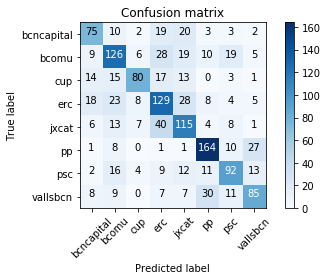

<Figure size 640x480 with 0 Axes>

In [50]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

cm = confusion_matrix(test_tags,predicted_label)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_plot_labels = text_labels

plot_confusion_matrix(cm, cm_plot_labels)

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# Entrenamos con todos los datos

El modelo parece que funciona pues entrenamos con todos los datos. El incremento en accuracy es notable. DL es muy sensible al numero de datos.

In [51]:
print(x_train.shape,x_test.shape)
all_x = np.concatenate((x_train,x_test))
all_y = np.concatenate((y_train,y_test))
print(all_x.shape)
history = model.fit(all_x, all_y,
                    batch_size=10,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=0.2)

(5775, 24241) (1444, 24241)
(7219, 24241)
Train on 5775 samples, validate on 1444 samples
Epoch 1/5
5775/5775 [==============================] - 6s 960us/step - loss: 0.1263 - acc: 0.9614 - val_loss: 1.2247 - val_acc: 0.5990
Epoch 2/5
5775/5775 [==============================] - 6s 954us/step - loss: 0.0223 - acc: 0.9977 - val_loss: 1.2564 - val_acc: 0.6046
Epoch 3/5
5775/5775 [==============================] - 6s 962us/step - loss: 0.0098 - acc: 0.9993 - val_loss: 1.2893 - val_acc: 0.6032
Epoch 4/5
5775/5775 [==============================] - 6s 973us/step - loss: 0.0060 - acc: 0.9995 - val_loss: 1.3343 - val_acc: 0.6011
Epoch 5/5
5775/5775 [==============================] - 6s 964us/step - loss: 0.0041 - acc: 0.9997 - val_loss: 1.3680 - val_acc: 0.5997


In [52]:
test = pd.read_excel('test-20190402-08_55_19-public.xlsx') # Load the `train` file
test.head()

,Id,text,created_at,retweet_count,favorite_count
0,0,"Avui tenim el pensament enllà dels Pirineus, a...",2018-10-15 20:00:43,91,254
1,1,"No he vist el teu a què fas referència, però ...",2017-12-17 10:49:49,0,5
2,2,Han decretat presó incondicional per una antif...,2019-03-31 19:16:20,85,121
3,3,¿Qué diríamos (y haríamos) si por ser hombre t...,2019-02-22 16:27:00,11,16
4,4,"""Ustedes que pueden, dialoguen"". Aquella exhor...",2019-03-23 21:17:05,8,17


In [53]:
test['text'] = test['text'].map(lambda com : clean_text(com))
test["text"] = test["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
x_new_test = vectorizer.transform(test["text"]).toarray()
predicted_label = [0] * len(x_new_test)

for i in range(len(x_new_test)):
    prediction = model.predict(np.array([x_new_test[i]]))
    predicted_label[i] = text_labels[np.argmax(prediction[0])]
    print("Predicted label: " + predicted_label[i])

Predicted label: bcomu
Predicted label: jxcat
Predicted label: jxcat
Predicted label: pp
Predicted label: erc
Predicted label: pp
Predicted label: erc
Predicted label: bcncapital
Predicted label: erc
Predicted label: erc
Predicted label: pp
Predicted label: pp
Predicted label: jxcat
Predicted label: cup
Predicted label: jxcat
Predicted label: bcomu
Predicted label: cup
Predicted label: bcomu
Predicted label: bcncapital
Predicted label: pp
Predicted label: bcomu
Predicted label: bcncapital
Predicted label: psc
Predicted label: vallsbcn
Predicted label: pp
Predicted label: erc
Predicted label: psc
Predicted label: cup
Predicted label: pp
Predicted label: bcncapital
Predicted label: psc
Predicted label: bcomu
Predicted label: erc
Predicted label: erc
Predicted label: bcncapital
Predicted label: erc
Predicted label: bcomu
Predicted label: erc
Predicted label: pp
Predicted label: pp
Predicted label: bcomu
Predicted label: erc
Predicted label: erc
Predicted label: psc
Predicted label: bcomu


Predicted label: pp
Predicted label: pp
Predicted label: erc
Predicted label: bcomu
Predicted label: bcomu
Predicted label: vallsbcn
Predicted label: vallsbcn
Predicted label: erc
Predicted label: bcomu
Predicted label: psc
Predicted label: cup
Predicted label: vallsbcn
Predicted label: bcomu
Predicted label: erc
Predicted label: bcncapital
Predicted label: jxcat
Predicted label: bcomu
Predicted label: erc
Predicted label: bcncapital
Predicted label: erc
Predicted label: erc
Predicted label: vallsbcn
Predicted label: pp
Predicted label: erc
Predicted label: bcomu
Predicted label: bcomu
Predicted label: pp
Predicted label: bcomu
Predicted label: erc
Predicted label: jxcat
Predicted label: erc
Predicted label: pp
Predicted label: erc
Predicted label: bcncapital
Predicted label: erc
Predicted label: psc
Predicted label: pp
Predicted label: jxcat
Predicted label: bcncapital
Predicted label: pp
Predicted label: bcomu
Predicted label: jxcat
Predicted label: erc
Predicted label: bcncapital
Pr

Predicted label: bcomu
Predicted label: jxcat
Predicted label: pp
Predicted label: cup
Predicted label: jxcat
Predicted label: vallsbcn
Predicted label: cup
Predicted label: pp
Predicted label: jxcat
Predicted label: cup
Predicted label: bcomu
Predicted label: bcomu
Predicted label: bcncapital
Predicted label: pp
Predicted label: vallsbcn
Predicted label: jxcat
Predicted label: vallsbcn
Predicted label: bcncapital
Predicted label: erc
Predicted label: cup
Predicted label: bcomu
Predicted label: pp
Predicted label: erc
Predicted label: pp
Predicted label: psc
Predicted label: erc
Predicted label: jxcat
Predicted label: erc
Predicted label: pp
Predicted label: bcomu
Predicted label: pp
Predicted label: cup
Predicted label: pp
Predicted label: bcncapital
Predicted label: psc
Predicted label: cup
Predicted label: psc
Predicted label: bcncapital
Predicted label: bcncapital
Predicted label: jxcat
Predicted label: psc
Predicted label: psc
Predicted label: erc
Predicted label: jxcat
Predicted 

Predicted label: pp
Predicted label: bcomu
Predicted label: bcncapital
Predicted label: jxcat
Predicted label: cup
Predicted label: pp
Predicted label: vallsbcn
Predicted label: bcomu
Predicted label: jxcat
Predicted label: vallsbcn
Predicted label: pp
Predicted label: jxcat
Predicted label: bcncapital
Predicted label: pp
Predicted label: vallsbcn
Predicted label: vallsbcn
Predicted label: bcncapital
Predicted label: vallsbcn
Predicted label: pp
Predicted label: vallsbcn
Predicted label: cup
Predicted label: erc
Predicted label: erc
Predicted label: jxcat
Predicted label: bcncapital
Predicted label: jxcat
Predicted label: jxcat
Predicted label: erc
Predicted label: erc
Predicted label: bcomu
Predicted label: jxcat
Predicted label: erc
Predicted label: pp
Predicted label: jxcat
Predicted label: jxcat
Predicted label: pp
Predicted label: cup
Predicted label: jxcat
Predicted label: bcomu
Predicted label: pp
Predicted label: bcomu
Predicted label: jxcat
Predicted label: bcomu
Predicted lab

Predicted label: bcomu
Predicted label: vallsbcn
Predicted label: jxcat
Predicted label: vallsbcn
Predicted label: vallsbcn
Predicted label: erc
Predicted label: pp
Predicted label: erc
Predicted label: jxcat
Predicted label: psc
Predicted label: psc
Predicted label: bcomu
Predicted label: psc
Predicted label: jxcat
Predicted label: erc
Predicted label: bcomu
Predicted label: bcomu
Predicted label: bcncapital
Predicted label: pp
Predicted label: jxcat
Predicted label: bcomu
Predicted label: psc
Predicted label: bcncapital
Predicted label: psc
Predicted label: pp
Predicted label: jxcat
Predicted label: cup
Predicted label: bcncapital
Predicted label: jxcat
Predicted label: erc
Predicted label: jxcat
Predicted label: erc
Predicted label: pp
Predicted label: bcncapital
Predicted label: erc
Predicted label: bcomu
Predicted label: pp
Predicted label: vallsbcn
Predicted label: cup
Predicted label: vallsbcn
Predicted label: pp
Predicted label: bcomu
Predicted label: bcncapital
Predicted label

Creamos el submission file para el kaggle

In [54]:
# 3 Create a the results file
output = pd.DataFrame({'Party': predicted_label})
output.index.name = 'Id'
output.to_csv('sample_submission.csv')

# TIP - Copy and paste this function to generate the output file in your code
def save_submission(prediction):
    import datetime
    t = datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")
    output = pd.DataFrame({'Party': prediction})
    output.index.name = 'Id'
    output.to_csv(f'sample_submission{t}.csv')
    
output.head()

,Party
Id,
0,bcomu
1,jxcat
2,jxcat
3,pp
4,erc
